# MLP:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

# Read match data and remove ID
match_data = pd.read_csv("match_data.csv")
match_data = match_data.drop(columns=['ID','Top', 'Jungle', 'Mid', 'Bot', 'Support', 'Enemy Top', 'Enemy Jungle', 'Enemy Mid', 'Enemy Bot', 'Enemy Support'])


### Preparing the dataset:

In [2]:
# Create training and testing split
train, test = train_test_split(match_data, test_size=0.2)
x_train, y_train = train.drop(columns=['Victory']), train['Victory']
x_test, y_test = test.drop(columns=['Victory']), test['Victory']

# Normalize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


### Hyperparameter tuning

In [6]:
mlp_classifier = MLPClassifier(max_iter=500)

parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'alpha': [0.0001, 0.05],
}

grid_logistic = GridSearchCV(mlp_classifier, param_grid=parameters, scoring='accuracy', cv=10)

grid_logistic.fit(x_train, y_train)

print("Tuned Hyperparameters :", grid_logistic.best_params_)
print("Accuracy :",grid_logistic.best_score_)

Tuned Hyperparameters : {'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50)}
Accuracy : 0.927005931551386


### Train the model

In [7]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 50, 50),\
                                learning_rate_init=0.03, alpha= 0.05,\
                                solver='sgd', activation='relu', \
                                max_iter=500, verbose=True)
mlp_classifier.fit(x_train, y_train)
y_train_pred = mlp_classifier.predict(x_train)
y_test_pred = mlp_classifier.predict(x_test)

Iteration 1, loss = 0.33037495
Iteration 2, loss = 0.16934148
Iteration 3, loss = 0.16584448
Iteration 4, loss = 0.16386592
Iteration 5, loss = 0.16278709
Iteration 6, loss = 0.16059606
Iteration 7, loss = 0.16206049
Iteration 8, loss = 0.16026084
Iteration 9, loss = 0.15962883
Iteration 10, loss = 0.16058711
Iteration 11, loss = 0.15819785
Iteration 12, loss = 0.15888641
Iteration 13, loss = 0.15869160
Iteration 14, loss = 0.15742595
Iteration 15, loss = 0.15742143
Iteration 16, loss = 0.15782561
Iteration 17, loss = 0.15658187
Iteration 18, loss = 0.15668547
Iteration 19, loss = 0.15679251
Iteration 20, loss = 0.15669767
Iteration 21, loss = 0.15570737
Iteration 22, loss = 0.15523324
Iteration 23, loss = 0.15564787
Iteration 24, loss = 0.15474803
Iteration 25, loss = 0.15463547
Iteration 26, loss = 0.15399919
Iteration 27, loss = 0.15440731
Iteration 28, loss = 0.15375334
Iteration 29, loss = 0.15407553
Iteration 30, loss = 0.15315059
Iteration 31, loss = 0.15358662
Iteration 32, los

### Evaluation metrics

In [8]:
# print("Training results:\n%s" % classification_report(y_train, y_train_pred))
print("Testing results:\n%s" % classification_report(y_test, y_test_pred))

training_mse = mean_squared_error(y_train.astype(int), y_train_pred.astype(int))
testing_mse = mean_squared_error(y_test.astype(int), y_test_pred.astype(int))

print("Training MSE: %s" % training_mse)
print("Testing MSE: %s" % testing_mse)

print("Variance: %s" % abs(testing_mse - training_mse))

# Save model
pickle.dump(mlp_classifier, open("mpl_model.pkl", 'wb'))

cm = confusion_matrix(y_test, y_test_pred)
print(cm)



Testing results:
              precision    recall  f1-score   support

       False       0.91      0.92      0.92      1713
        True       0.92      0.91      0.91      1617

    accuracy                           0.92      3330
   macro avg       0.92      0.92      0.92      3330
weighted avg       0.92      0.92      0.92      3330

Training MSE: 0.0457344547912286
Testing MSE: 0.08348348348348349
Variance: 0.03774902869225489
[[1582  131]
 [ 147 1470]]


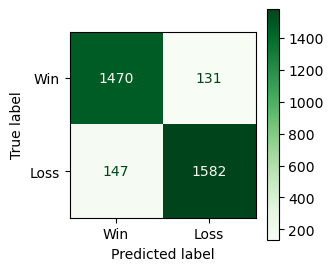

In [9]:
disp = ConfusionMatrixDisplay.from_predictions(
                  y_test_pred,
                  y_test, 
                  labels=[1,0],
                  cmap=plt.cm.Greens,
                  display_labels=['Win','Loss'], 
                  values_format='',  
) 
fig = disp.ax_.get_figure() 
fig.set_figwidth(3)
fig.set_figheight(3) 

plt.show()

In [1]:
# Load and test model
import pickle
import pandas as pd

# Load model from file
model = pickle.load(open("model", 'rb'))

# Input data
# For the front end, we could just create a one row dataframe.
# I think columns should be in the same order as during training.
input_data = pd.read_csv("match_data.csv")
input_data = input_data.drop(columns=['ID'])
categorical_data = ['Top', 'Jungle', 'Mid', 'Bot', 'Support', 'Enemy Top', 'Enemy Jungle', 'Enemy Mid', 'Enemy Bot', 'Enemy Support']

# Testing the first 100 rows of the dataset
# Each row is passed into the model separately
for k in range(0, 101):
    
    # Gets a row of data from our dataset. In our front end, we won't be doing this
    # as we'll be getting user input instead
    input = input_data.loc[[k]]

    # Need to get the same one hot encodings as during training
    # Pandas creates one hot encodings by creating new columns, so
    # need to get back those columns in same order.

    # Create one hot encoding for our input data
    input = pd.get_dummies(input, columns=categorical_data)
    # Get all columns from file which should be saved from training
    categories = pickle.load(open("categories_with_encoding", 'rb'))
    # Reindex the input data so it includes all the columns in the same order
    input = input.reindex(columns=categories, fill_value=0)

    # Just to verify that the columns are the same between
    # our input data and the columns from training
    input_column_list = input.columns.tolist()
    for i in range(0, len(categories)):
        if input_column_list[i] != categories[i]:
            print("mismatch, %s is not %s", (input_column_list[i], categories[i]))


    X, Y = input.drop(columns=["Victory"]), input["Victory"]

    # Normalize data with the saved scaler
    scaler = pickle.load(open("scaler", 'rb'))
    X = scaler.transform(X)
    
    # Make the prediction and report results
    prediction = model.predict(X)
    if prediction[0] == True:
        print("Predicted: %s" % prediction)
        print("Actual: %s\n" % Y.values)
    else:
        print("Predicted: %s" % prediction)
        print("Actual: %s\n" % Y.values)

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [ True]

Predicted: [False]
Actual: [False]

Predicted: [ True]
Actual: [